# Simple Kriging



- A krigagem assume que a distância ou direção entre os pontos amostrais reflete uma **correlação espacial** que pode ser usada para explicar a variação na superfície.

-  A ferramenta Krigagem ajusta uma função matemática a um número específico de pontos, ou a todos os pontos dentro de um raio especificado, para determinar o valor de saída para cada localização

- apropriada quando você sabe que há uma distância espacialmente correlacionada ou um **viés direcional nos dados**
  - Como garantir que há ?

- Parte-se do pressuposto de que amostras
localizadas em regiões próximas são mais similares e estão mais correlacionadas do que amostras distantes
- O que siginifica estar próxima ?
  - Como essas amostras estão correlacionadas
  - Qual a distância entre elas


- Média ponderada que segue a equação

$$ Z^{*}(x_0) = \sum _{i=1}^{n} \lambda_i Z(x_i) $$

- Pesos maiores são atribuidos para amostras mais próximas
- Amostras originais próximas são redundantes e podem compartilhar o mesmo peso

$$ Z^{*}(\bar{x_0}) = \mu(\bar{x}) + \sum _{i=1}^{n} \lambda_i (Z(\bar{x_i} - \mu(\bar{x}))) $$
$$ A\lambda = b$$


### Passos
1. Determinação do Variograma
2. Ajuste de um modelo ao Variograma empírico
3. Utilização dos dados para previsões

### Determinação do vetor de pesos
- $A$: Matriz de semivariância entre os pontos  da i-esima e j-esima amostra (Constante, independe da posição da nova amostra)
- $\lambda$ : Vetor de Pesos
- $b$ : Vetor de semivariâncias entre os pontos de cada amostra e da amostra "alvo"

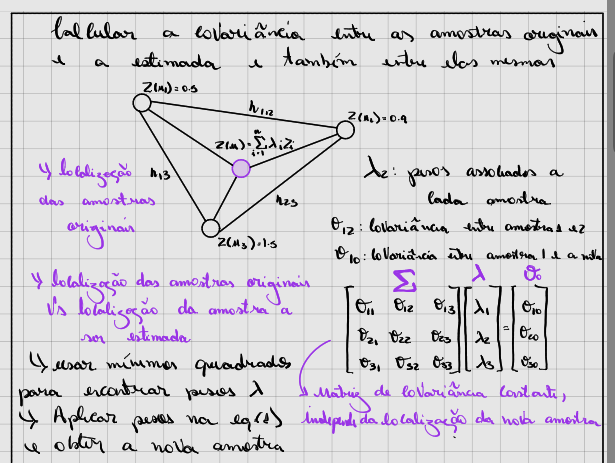





## 1. Importando dados


In [82]:
from pylab import *
import numpy as np
from pandas import DataFrame, Series
from scipy.spatial.distance import pdist, squareform

data = open( './ZoneA.dat','r' ).readlines()
data = [ i.strip().split() for i in data[10:] ]
data = np.array( data, dtype=float )
data = DataFrame( data, columns=['x','y','thk','por','perm','lperm','lpermp','lpermr'] )


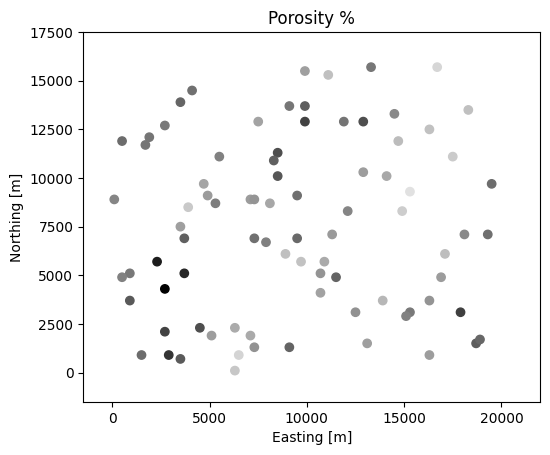

In [83]:
fig, ax = subplots()
ax.scatter( data.x, data.y, c=data.por, cmap='gray' )
ax.set_aspect(1)
xlim(-1500,22000)
ylim(-1500,17500)
xlabel('Easting [m]')
ylabel('Northing [m]')
title('Porosity %') ;

## 2. Modelando Semivariograma

- O semivariograma codifica dados sobre a variância espacial ao longo de uma região  dada uma distância ou defasagem

- É esperado que dados que estão próximos compartilhem mais características do que dados que estão separados por grandes distâncias

-  O semivariograma nos permite modelar os pontos de similaridade em um campo em função da distância.

- Ele pode ser definido como a soma dos quadrados das diferenças entre valores separados por uma distância $h$

$$
\gamma (h) = \frac{1}{2N(h)}\sum (z_i - z_j)^2
$$

- $h$: distância entre os pontos $z_i$ e $z_j$

- $N(h)$: número de pontos separados pela distância $h$

Enquanto a variância é dada por:

$$
s = \frac{1}{N - 1} \sum_{k=1}^{N} (z_k - \hat{\mu })^2
$$

- $N$: número de pontos dados
- $\hat{\mu }$: média





In [46]:
  # param P: array contendo coordenadas espaciais e o valor da varíavel nesse ponto
  #     [x, y, P(x, y)]
  #  param h: Distânciaentre os pontos
  #  param bandWidth: Largura da banda para considerar pares de pontos.

class Semivariogram():
    def __init__(self, data, bandWidth, h_max):
      self.P = np.array(data[['x','y','por']])
      self.bw = bandWidth
      self.hs = np.arange(0, h_max, bandWidth)

    # Calcula o variograma experimental para uma única distância h
    def SVh(self, P, h, bw):
      points_distance = squareform(pdist(P[:, :2]))  # Calcula as distâncias entre todos os pontos
      mask = (points_distance >= h - bw) & (points_distance <= h + bw) # Selecionar as distâncias que estão dentro da faixa de interesse (h - bw a h + bw).
      i, j = np.triu_indices_from(points_distance, k=1) # Obter elementos acima da diagonal principal
      valid_pairs = mask[i, j] # Selecionar os pares válidos
      Z = (P[i[valid_pairs], 2] - P[j[valid_pairs], 2]) ** 2
      return np.sum(Z) / (2.0 * len(Z))

    # Calcula o variograma experimental para um conjunto de distâncias hs
    def SV(self, P, hs, bw):
      sv = list()
      for h in hs:
          sv.append(self.SVh( P, h, bw ))
      sv = [[hs[i], sv[i]] for i in range(len( hs )) if sv[i] > 0]
      return np.array(sv).T

    # Calcula a função de covariância para uma distância h
    def Covariance(self, P, h, bw ):
        c0 = np.var(P[:,2]) # P(x, y)
        if h == 0:
            return c0
        return c0 - self.SVh( P, h, bw )

    def PlotSemivariogram(self):
      self.sv = self.SV(self.P, self.hs, self.bw)
      plot(self.sv[0], self.sv[1], '.-')
      xlabel('Lag [m]')
      ylabel('Semivariance')
      title('Sample Semivariogram')


- *Selecionar apenas os pontos que estão acima da diagonal principal (na matriz de distâncias) ao calcular o semivariograma é importante porque o semivariograma é simétrico. Isto significa que a distância entre o ponto $i$ e o ponto $𝑗$ é a mesma que a distância entre o ponto $j$ e o ponto $i$. Incluir ambos os pares resultaria em contagem dupla, o que não é necessário e pode aumentar o tempo de computação sem adicionar qualquer nova informação.*

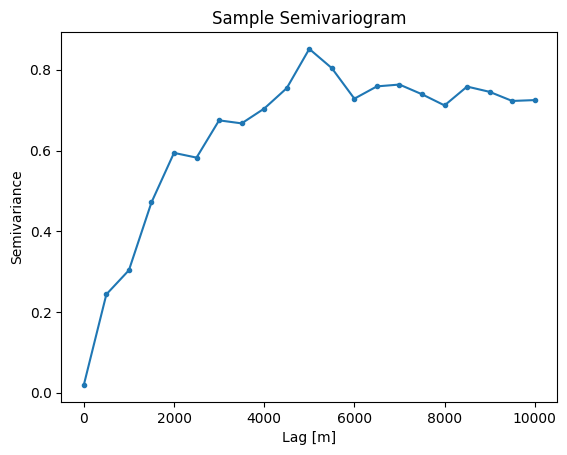

In [47]:
# bandwidth: +- 250m
semivariogram = Semivariogram(data=data, bandWidth=500, h_max=10500)
semivariogram.PlotSemivariogram()


### Interpretando o Semivariograma

- Suponha que estamos analisando a porosidade do solo em diferentes locais.
- O semivariograma nos ajuda a entender como a porosidade varia espacialmente.
- Se o semivariograma mostrar que a semivariância aumenta rapidamente e depois se estabiliza, isso sugere que **há correlação espacial na porosidade do solo até uma certa distância** (range).
- Além dessa distância, **as medições de porosidade são essencialmente independentes** umas das outras.

## 2. Modelagem

- Definido o semivariograma, é preciso ajustar um modelo aos dados


### Definição de Sill

- **Sill** é o valor ao qual o semivariograma se estabiliza à medida que a distância (lag) entre os pontos aumenta. Em outras palavras, é a variação total ou a variância da variável estudada quando a dependência espacial não é mais significativa.
- No gráfico de um semivariograma, o sill é a altura (valor do eixo y) onde a curva do semivariograma se nivela, geralmente após um certo lag (distância).

### Importância do Sill

- **Variabilidade Total**: O sill representa a variabilidade total da variável espacial. Quando o lag é grande o suficiente para que não haja mais correlação espacial entre os pontos, o valor do semivariograma se aproxima do sill.
- **Comparação entre Modelos**: O sill é usado para comparar diferentes modelos de semivariograma. Modelos bem ajustados têm um sill que corresponde aproximadamente à variância dos dados.
- **Parâmetro do Modelo**: Em muitos modelos de semivariograma (como o esférico, exponencial e gaussiano), o sill é um parâmetro essencial que define a forma da função.

### Componentes do Semivariograma

1. **Nugget Effect (Nugget)**: Representa a variância a uma distância muito pequena (quase zero), indicando pequenas variações ou erros de medição.
2. **Range**: A distância além da qual a variabilidade espacial se estabiliza e o semivariograma atinge o sill.
3. **Sill**: O valor da semivariância quando a distância entre os pontos é suficientemente grande para que não haja correlação espacial significativa.

### Visualização

Em um gráfico de semivariograma:

- O eixo x representa a distância (lag) entre pares de pontos.
- O eixo y representa a semivariância, que é metade da variância das diferenças entre os valores da variável para pares de pontos separados por essa distância.
- O gráfico geralmente começa no nugget e sobe até se estabilizar no sill.

### Exemplo de Modelos de Semivariograma

1. **Modelo Esférico**:
   $$
   \gamma(h) =
   \begin{cases}
   C_0 \left(1.5 \frac{h}{a} - 0.5 \left(\frac{h}{a}\right)^3 \right) & \text{se } h \leq a \\
   C_0 & \text{se } h > a
   \end{cases}
   $$

2. **Modelo Exponencial**:
   $$
   \gamma(h) = C_0 \left(1 - \exp\left(-\frac{h}{a}\right)\right)
   $$

3. **Modelo Gaussiano**:
   $$
   \gamma(h) = C_0 \left(1 - \exp\left(-\left(\frac{h}{a}\right)^2\right)\right)
   $$
   Onde $C_0$ é o sill e $a$ é o range.


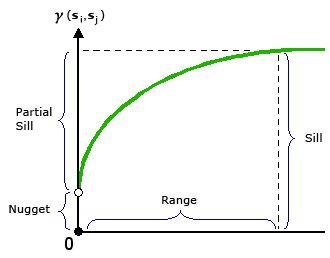

In [48]:
import numpy as np
import matplotlib.pyplot as plt

class Modelling:
    def __init__(self, semivariogram):
        self.sv = semivariogram.sv
        self.P = semivariogram.P
        self.bw = semivariogram.bw
        self.hs = semivariogram.hs

  # Otimiza um parâmetro de um modelo de semivariograma.
  # Computa o mse entre os valores observados e os valores preditos pelo modelo
  # Para uma serie de parametros e escolhe o que leva ao menor erro
    def opt(self, fct, x, y, sill, parameterRange, meshSize):
        prameters = np.linspace(parameterRange[0], parameterRange[1], meshSize)
        mse = np.zeros(meshSize)
        for i in range(meshSize):
            mse[i] = np.mean((y - np.array(fct(x, prameters[i], sill))) ** 2.0)
        return prameters[mse.argmin()]

    def spherical(self, h, range, sill):
        h = np.asarray(h)
        gamma = np.where(h <= range, sill * (1.5 * (h / range) - 0.5 * (h / range) ** 3), sill)
        return gamma

    def exponential(self, h, range, sill):
        h = np.asarray(h)
        gamma = sill * (1 - np.exp(-h / range))
        return gamma

    def gaussian(self, h, range, sill):
        h = np.asarray(h)
        gamma = sill * (1 - np.exp(- (h / range) ** 2))
        return gamma

    def cvmodel(self, model):
        sill = np.var(self.P[:, 2]) # Variancia dos pontos P(x, y)
        range = self.opt(model, self.sv[0], self.sv[1], sill, [self.hs[1], self.hs[-1]], 100)
        return lambda h: model(h, range, sill)

    def plotModel(self, model, model_name):
        sp = self.cvmodel(model)
        plt.plot(self.sv[0], self.sv[1], '.-', label='Empirical')
        plt.plot(self.sv[0], sp(self.sv[0]), label=f'{model_name} Model')
        plt.title(f'{model_name} Model')
        plt.ylabel('Semivariance')
        plt.xlabel('Lag [m]')
        plt.legend()
        plt.show()

    def calculate_mse(self, model):
        sp = self.cvmodel(model)
        mse = np.mean((self.sv[1] - sp(self.sv[0])) ** 2.0)
        return mse

    def FindBetter(self):
        models = {
            "Spherical": self.spherical,
            "Exponential": self.exponential,
            "Gaussian": self.gaussian
        }
        mse_values = {name: self.calculate_mse(model) for name, model in models.items()}
        best_model_name = min(mse_values, key=mse_values.get)
        print(f"Mse: {mse_values} => Melhor modelo: {best_model_name}")

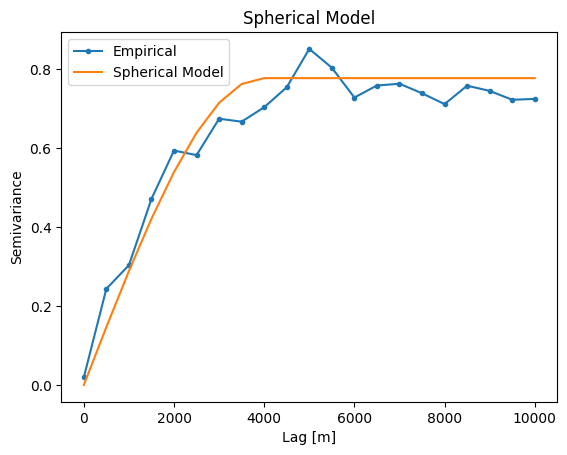

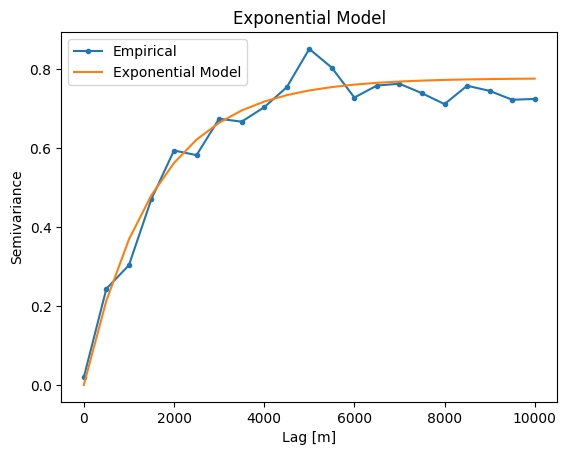

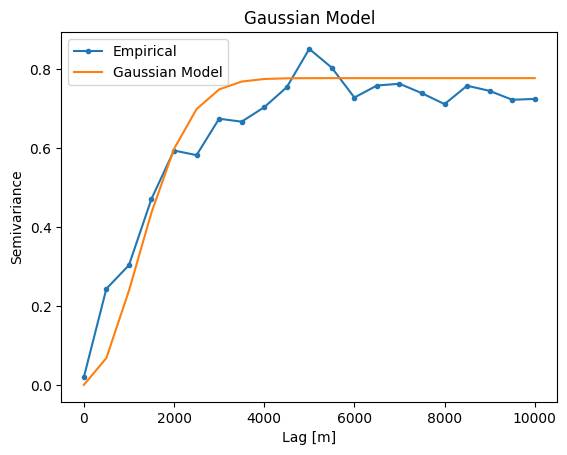

Mse: {'Spherical': 0.0027443753933582486, 'Exponential': 0.0017020934088127317, 'Gaussian': 0.004470059995505123} => Melhor modelo: Exponential


In [49]:
model = Modelling(semivariogram)
model.plotModel(model.spherical, "Spherical")
model.plotModel(model.exponential, "Exponential")
model.plotModel(model.gaussian, "Gaussian")
model.FindBetter()

### Para encontrar os pesos que minimizem a variância

$$ \lambda = A^{-1} b$$

In [161]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import plotly.figure_factory as ff
import plotly.offline as py
from scipy.spatial import Delaunay
import plotly.graph_objs as go
from plotly.subplots import make_subplots

'''
  Input:
      model (function): Modeling function (spherical, exponential, gaussian)
      u     (tuple): Unsampled point (x, y)
      N     (int): Number of neighboring points to consider
  Output:
      float: Kriged estimate at point u
'''
class Kriging():
    def __init__(self, semivariogram, model):
        self.sv = semivariogram.sv
        self.P = semivariogram.P
        self.bw = semivariogram.bw
        self.hs = semivariogram.hs
        self.model = model

    def SimpleKriging(self, model, unsampled_point, N):
      covfct = self.model.cvmodel(model) # Covariance function
      mu = np.mean(self.P[:, 2]) # Mean of the variable P(x, y)

      # Distance between the unsampled point and each data point in P
      unsampled_distances = np.sqrt((self.P[:, 0] - unsampled_point[0]) ** 2.0 +
                                    (self.P[:, 1] - unsampled_point[1]) ** 2.0)

      P = np.vstack((self.P.T, unsampled_distances)).T  # Add these distances to P
      P = P[unsampled_distances.argsort()[:N]]  # Sort P by these distances and take the first N of them

      # Apply the covariance model to the distances
      cov_vector = np.matrix(covfct(P[:, 3])).T

      # Distance between each data point in P
      distances = pdist(P[:, :2])
      cov_matrix = np.matrix(squareform(covfct(distances))) # matrix of covariance for each distance

      # Calculate the kriging weights
      weights = np.linalg.inv(cov_matrix) * cov_vector
      weights = np.array(weights)

      # Calculate the residuals
      residuals = P[:, 2] - mu

      # Calculate the estimation
      estimation = np.dot(weights.T, residuals) + mu

      return float(estimation)


    def predictUnsampled(self, model, mesh_x=80, mesh_y=100):
        X0, X1 = self.P[:, 0].min(), self.P[:, 0].max()
        Y0, Y1 = self.P[:, 1].min(), self.P[:, 1].max()
        Z = np.zeros((mesh_x, mesh_y))
        dx, dy = (X1 - X0) / mesh_y, (Y1 - Y0) / mesh_x

        X, Y = [], []
        for i in range(mesh_x):
            print(i, end=' ')
            for j in range(mesh_y):
                Z[i, j] = self.SimpleKriging(model, (dx * j, dy * i), 16)
                X.append(dx * j)
                Y.append(dy * i)
        self.X =  np.array(X)
        self.Y =  np.array(Y)
        self.Z =  Z

    def PlotKriging(self, model, model_name, mesh_x=80, mesh_y=100):
        fig, ax = plt.subplots()

        H = np.zeros_like(self.Z)
        for i in range(self.Z.shape[0]):
            for j in range(self.Z.shape[1]):
                H[i, j] = np.round(self.Z[i, j] * 3)

        im = ax.matshow(H, cmap='viridis', interpolation='nearest')
        ax.scatter(self.P[:, 0] / 200.0, self.P[:, 1] / 200.0, facecolor='none', linewidths=0.75, s=50)
        ax.set_xlim(0, 99)
        ax.set_ylim(0, 80)
        ax.set_xticks([25, 50, 75])
        ax.set_xticklabels([5000, 10000, 15000])
        ax.set_yticks([25, 50, 75])
        ax.set_yticklabels([5000, 10000, 15000])
        plt.xlabel('Lag [m]')
        plt.ylabel('Semivariance')
        plt.title(f'Kriging Map ({model_name})')
        plt.colorbar(im)
        plt.show()


In [ ]:
def PlotSurface(X, Y, Z, data, model_name, mesh_x=80, mesh_y=100):
      x_sup, y_sup, z_sup =  data.x, data.y, data.por
      x_orig, y_orig, z_orig =  data.x, data.y, data.por

      points = np.column_stack((x_sup, y_sup))
      tri = Delaunay(points)

      fig_surface = ff.create_trisurf(x=x_sup, y=y_sup, z=z_sup,
                                      simplices=tri.simplices, colormap='Greys')

      fig_orig_data =  go.Scatter3d(
              x=x_orig,
              y=y_orig,
              z=z_orig,
              mode='markers',
              marker=dict(
              size=5,
              color='red',
              opacity=0.8
              ),
              name='Original Samples'
      )

      virtual_surface = go.Surface(x=X.reshape(mesh_x, mesh_y),
                                    y=Y.reshape(mesh_x, mesh_y),
                                    z=Z)
      fig = make_subplots(rows=1,
                          cols=2,
                          subplot_titles=(f'Original Surface ({model_name})',
                                          f'Virtual Surface ({model_name})'),
                          specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]])

      fig.add_trace(go.Scatter3d(x=x_orig, y=y_orig, z=z_orig, mode='markers',
                                  marker=dict(size=5, color='red', opacity=0.8),
                                  name='Original Samples'), row=1, col=1)
      fig.add_trace(fig_surface.data[0], row=1, col=1)

      fig.add_trace(go.Scatter3d(x=x_orig, y=y_orig, z=z_orig, mode='markers',
                                  marker=dict(size=5, color='red', opacity=0.8),
                                  showlegend=False), row=1, col=2)
      fig.add_trace(virtual_surface, row=1, col=2)

      py.iplot(fig)

In [162]:
kriging = Kriging(semivariogram, model)

In [163]:
kriging.predictUnsampled(model.spherical)

0 

<ipython-input-161-d76f8e564358>:53: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 

In [184]:
PlotSurface(kriging.X, kriging.Y, kriging.Z, data, "Spherical")

In [185]:
kriging.predictUnsampled(model.exponential)

0 

<ipython-input-161-d76f8e564358>:53: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 

In [186]:
PlotSurface(kriging.X, kriging.Y, kriging.Z, data, "Exponential")

In [187]:
kriging.predictUnsampled(model.gaussian)

0 

<ipython-input-161-d76f8e564358>:53: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 

In [188]:
PlotSurface(kriging.X, kriging.Y, kriging.Z, data, "Gaussian")

0 

<ipython-input-161-d76f8e564358>:53: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 

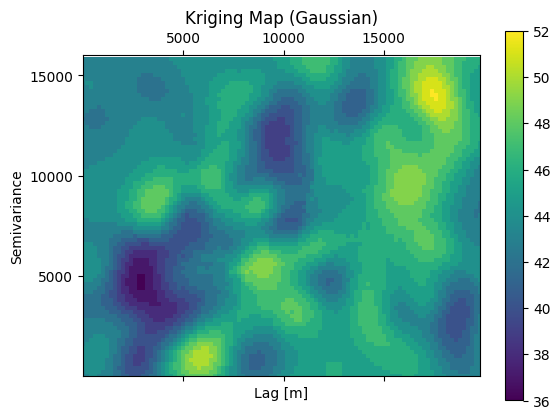

In [192]:
kriging.predictUnsampled(model.gaussian)
kriging.PlotKriging(model.gaussian, "Gaussian")

0 

<ipython-input-161-d76f8e564358>:53: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 

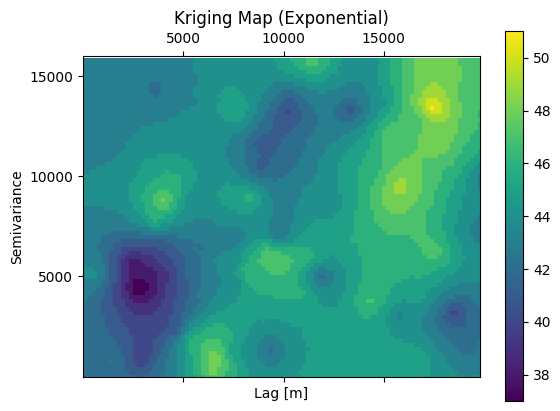

In [191]:
kriging.predictUnsampled(model.exponential)
kriging.PlotKriging(model.exponential, "Exponential")

0 

<ipython-input-161-d76f8e564358>:53: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 

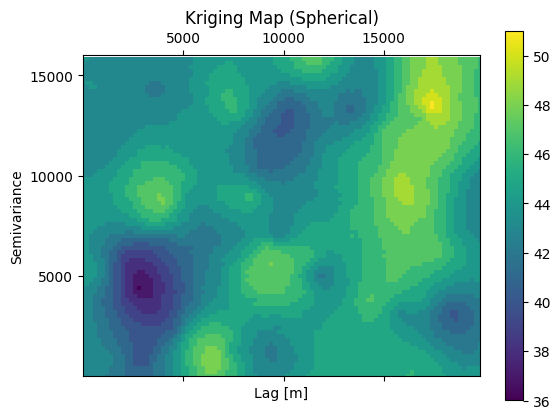

In [190]:
kriging.predictUnsampled(model.spherical)
kriging.PlotKriging(model.spherical, "Spherical")

# Referência bibliográfica


[1] [KRIGAGEM SIMPLES EM PYTHON]( https://connor-johnson.com/2014/03/20/simple-kriging-in-python/)

[2] [Como funciona Krigagem](https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/how-kriging-works.htm)